<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D5/tutorials/W3D5_DeepLearning2/W3D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 5, Tutorial 2
# Deep Learning 2: Autoencoder extensions

__Content creators:__ Marco Brigham and the [CCNSS](https://www.ccnss.org/) team (2014-2018)

__Content reviewers:__ Itzel Olivos, Karen Schroeder, Karolina Stosio, Kshitij Dwivedi, Spiros Chavlis and Michael Waskom

---
# Tutorial Objectives

## Architecture
How can we improve the internal representation of shallow autoencoder with 2D bottleneck layer? 

We may try the following architecture changes:
* Introducing additional hidden layers
* Wrapping latent space as a sphere

&nbsp;

![Deep ANN autoencoder](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/ae-ann-3h.png)

Adding hidden layers increases the number of learnable parameters to better use non-linear operations in encoding/decoding. Spherical geometry of latent space forces the network to use these additional degrees of freedom more efficiently.

Let's dive deeper into the technical aspects of autoencoders and improve their internal representations to reach the levels required for the *MNIST cognitive task*.

In this tutorial, you will:
- Increase the capacity of the network by introducing additional hidden layers
- Understand the effect of constraints in the geometry of latent space

In [1]:
#@title Video 1: Tutorial 2
# from IPython.display import YouTubeVideo
# video = YouTubeVideo(id="Lb2ycpMC7oM", width=854, height=480, fs=1)
# print("Video available at https://youtube.com/watch?v=" + video.id)
# video

---
# Setup
Please execute the cell(s) below to initialize the notebook environment.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

import sklearn as sk
from sklearn import manifold, decomposition
from sklearn.datasets import fetch_openml

!pip install plotly --quiet
import plotly.graph_objects as go
from plotly.colors import qualitative

In [3]:
# @title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
# @title Helper functions


def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train, (len(x_train), 28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test, (len(x_test), 28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)


def init_weights_kaiming_uniform(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming uniform distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming uniform distribution
    nn.init.kaiming_uniform_(layer.weight.data)


def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)


def get_layer_weights(layer):
  """
  Retrieves learnable parameters from PyTorch layer.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    list with learnable parameters
  """
  # initialize output list
  weights = []

  # check whether layer has learnable parameters
  if layer.parameters():
    # copy numpy array representation of each set of learnable parameters
    for item in layer.parameters():
      weights.append(item.detach().numpy())

  return weights


def print_parameter_count(net):
  """
  Prints count of learnable parameters per layer from PyTorch network.

  Args:
    net (torch.Sequential)
        Pytorch network

  Returns:
    Nothing.
  """

  params_n = 0

  # loop all layers in network
  for layer_idx, layer in enumerate(net):

    # retrieve learnable parameters
    weights = get_layer_weights(layer)
    params_layer_n = 0

    # loop list of learnable parameters and count them
    for params in weights:
      params_layer_n += params.size

    params_n += params_layer_n
    print(f'{layer_idx}\t {params_layer_n}\t {layer}')

  print(f'\nTotal:\t {params_n}')


def eval_mse(y_pred, y_true):
  """
  Evaluates mean square error (MSE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.MSELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates binary cross-entropy (BCE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
    criterion = nn.BCELoss()
    loss = criterion(y_pred, y_true)

  return float(loss)


def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1]+list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

    plt.tight_layout()


def to_s2(u):
  """
  Projects 3D coordinates to spherical coordinates (theta, phi) surface of
  unit sphere S2.
  theta: [0, pi]
  phi: [-pi, pi]

  Args:
    u (list, numpy array or torch.Tensor of floats)
        3D coordinates

  Returns:
    Sperical coordinates (theta, phi) on surface of unit sphere S2.
  """

  x, y, z = (u[:, 0], u[:, 1], u[:, 2])
  r = np.sqrt(x**2 + y**2 + z**2)
  theta = np.arccos(z / r)
  phi = np.arctan2(x, y)

  return np.array([theta, phi]).T


def to_u3(s):
  """
  Converts from 2D coordinates on surface of unit sphere S2 to 3D coordinates
  (on surface of S2), i.e. (theta, phi) ---> (1, theta, phi).

  Args:
    s (list, numpy array or torch.Tensor of floats)
        2D coordinates on unit sphere S_2

  Returns:
    3D coordinates on surface of unit sphere S_2
  """

  theta, phi = (s[:, 0], s[:, 1])
  x = np.sin(theta) * np.sin(phi)
  y = np.sin(theta) * np.cos(phi)
  z = np.cos(theta)

  return np.array([x, y, z]).T


def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum
  and maximum of x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted

  Returns:
    Nothing.
  """

  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  x_min = x_min - np.abs(x_max - x_min) * 0.05 - np.finfo(float).eps
  x_max = x_max + np.abs(x_max - x_min) * 0.05 + np.finfo(float).eps

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]


def plot_generative(x, decoder_fn, image_shape, n_row=16, s2=False):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in
  latent space that is determined by minimum and maximum values in x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D or 3D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row (integer)
        number of rows in grid

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  if s2:
    x = to_s2(np.array(x))

  xlim, ylim = xy_lim(np.array(x))

  dx = (xlim[1] - xlim[0]) / n_row
  grid = [np.linspace(ylim[0] + dx / 2, ylim[1] - dx / 2, n_row),
          np.linspace(xlim[0] + dx / 2, xlim[1] - dx / 2, n_row)]

  canvas = np.zeros((image_shape[0] * n_row, image_shape[1] * n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([[latent_x, latent_y]], dtype=np.float32)

      if s2:
        latent = to_u3(latent)

      with torch.no_grad():
        x_decoded = decoder_fn(torch.from_numpy(latent))

      x_decoded = x_decoded.reshape(image_shape)

      canvas[j * image_shape[0]: (j + 1) * image_shape[0],
             i * image_shape[1]: (i + 1) * image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, s2=False, fontdict=None, xy_labels=None):
  """
  Plots digit class of each sample in 2D latent space coordinates.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    fontdict (dictionary)
        style option for plt.text

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 12}

  if s2:
    x = to_s2(np.array(x))

  cmap = plt.get_cmap('tab10')

  if len(x) > show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
             color=cmap(int(my_y) / 10.),
             fontdict=fontdict,
             horizontalalignment='center',
             verticalalignment='center',
             alpha=0.8)

  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)

  if s2:
    if xy_labels is None:
      xy_labels = [r'$\varphi$', r'$\theta$']

    plt.xticks(np.arange(0, np.pi + np.pi / 6, np.pi / 6),
               ['0', '$\pi/6$', '$\pi/3$', '$\pi/2$',
                '$2\pi/3$', '$5\pi/6$', '$\pi$'])
    plt.yticks(np.arange(-np.pi, np.pi + np.pi / 3, np.pi / 3),
               ['$-\pi$', '$-2\pi/3$', '$-\pi/3$', '0',
                '$\pi/3$', '$2\pi/3$', '$\pi$'])

  if xy_labels is None:
    xy_labels = ['$Z_1$', '$Z_2$']

  plt.xlabel(xy_labels[0])
  plt.ylabel(xy_labels[1])


def plot_latent_generative(x, y, decoder_fn, image_shape, s2=False,
                           title=None, xy_labels=None):
  """
  Two horizontal subplots generated with encoder map and decoder grid.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    title (string)
        plot title

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12, 6))

  if title is not None:
    fig.suptitle(title, y=1.05)

  ax = fig.add_subplot(121)
  ax.set_title('Encoder map', y=1.05)
  plot_latent(x, y, s2=s2, xy_labels=xy_labels)

  ax = fig.add_subplot(122)
  ax.set_title('Decoder grid', y=1.05)
  plot_generative(x, decoder_fn, image_shape, s2=s2)

  plt.tight_layout()
  plt.show()


def plot_latent_3d(my_x, my_y, show_text=True, show_n=500):
  """
  Plot digit class or marker in 3D latent space coordinates.

  Args:
    my_x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    my_y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    show_text (boolean)
        whether to show text

    image_shape (tuple or list)
        original shape of image

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    title (string)
        plot title

  Returns:
    Nothing.
  """

  layout = {'margin': {'l': 0, 'r': 0, 'b': 0, 't': 0},
            'scene': {'xaxis': {'showspikes': False,
                                'title': 'z1'},
                      'yaxis': {'showspikes': False,
                                'title': 'z2'},
                      'zaxis': {'showspikes': False,
                                'title': 'z3'}}
            }

  selected_idx = np.random.choice(len(my_x), show_n, replace=False)

  colors = [qualitative.T10[idx] for idx in my_y[selected_idx]]

  x = my_x[selected_idx, 0]
  y = my_x[selected_idx, 1]
  z = my_x[selected_idx, 2]

  text = my_y[selected_idx]

  if show_text:

    trace = go.Scatter3d(x=x, y=y, z=z, text=text,
                         mode='text',
                         textfont={'color': colors, 'size': 12}
                         )

    layout['hovermode'] = False

  else:

    trace = go.Scatter3d(x=x, y=y, z=z, text=text,
                         hoverinfo='text', mode='markers',
                         marker={'size': 5, 'color': colors, 'opacity': 0.8}
                         )

  fig = go.Figure(data=trace, layout=layout)

  fig.show()


def runSGD(net, input_train, input_test, criterion='bce',
           n_epochs=10, batch_size=32, verbose=True):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        whether to print epoch loss and training loss plot

  Returns:
    Nothing.
  """

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    for batch in batches:

      output_train = net(batch)
      loss = loss_fn(output_train, batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, input_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, input_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    if verbose:
      print(loss_epoch)

  # Print loss
  loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
  loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
  print(loss_mse)

  loss_bce = f'BCE\t {eval_bce(output_train, input_train):0.4f}'
  loss_bce += f'\t\t {eval_bce(output_test, input_test):0.4f}'
  print(loss_bce)

  # Plot loss
  if verbose:
    step = int(np.ceil(len(track_loss) / 500))
    x_range = np.arange(0, len(track_loss), step)
    plt.figure()
    plt.plot(x_range, track_loss[::step], 'C0')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim([0, None])
    plt.ylim([0, None])
    plt.show()


class NormalizeLayer(nn.Module):
  """
  pyTorch layer (nn.Module) that normalizes activations by their L2 norm.

  Args:
      None.

  Returns:
      Object inherited from nn.Module class.
  """

  def __init__(self):
    super().__init__()

  def forward(self, x):
    return nn.functional.normalize(x, p=2, dim=1)

---
# Section 1: Download  and prepare MNIST dataset
We use the helper function `downloadMNIST()` to download the dataset and transform it into `torch.Tensor` and assign train and test sets to (`x_train`, `y_train`) and (`x_test`, `y_test`).

The variable `input_size` stores the length of *vectorized* versions of the images `input_train` and `input_test` for training and test images.

**Instructions**
* Please execute the cell below:

In [5]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train / 255
x_test = x_test / 255

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

print(f'shape image \t \t {image_shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')

shape image 	 	 torch.Size([28, 28])
shape input_train 	 torch.Size([60000, 784])
shape input_test 	 torch.Size([10000, 784])


---
# Section 2: Deeper autoencoder (2D)
The internal representation of shallow autoencoder with 2D latent space is similar to PCA, which shows that the autoencoder is not fully leveraging non-linear capabilities to model data. Adding capacity in terms of learnable parameters takes advantage of non-linear operations in encoding/decoding to capture non-linear patterns in data.

Adding hidden layers enables us to introduce additional parameters, either layerwise or depthwise. The same amount $N$ of additional parameters can be added in a single layer or distributed among several layers. Adding several hidden layers reduces the compression/decompression ratio of each layer.

## Exercise 1: Build deeper autoencoder (2D)
Implement this deeper version of the ANN autoencoder by adding four hidden layers. The number of units per layer in the encoder is the following:

```
784 -> 392 -> 64 -> 2
```

The shallow autoencoder has a compression ratio of **784:2=392:1**. The first additional hidden layer has a compression ratio of **2:1**,  followed by a hidden layer that sets the bottleneck compression ratio of **32:1**.

The choice of hidden layer size was mostly empirical and aimed at reducing the compression rate in the bottleneck layer. We also consider the need for trainable parameters. For example, if the first hidden layer's compression rate is doubled to **4:1**, the count of trainable parameters halves from 667K to 333K.

&nbsp;

This deep autoencoder's performance may be further improved by adding additional hidden layers and by increasing the count of trainable parameters in each layer. These improvements have a diminishing return due to challenges associated with training under high parameter count and depth. One option explored in the extended exercises is to add a first hidden layer with 2x - 3x the input size. This size increase results in millions of parameters at the cost of longer training time.

&nbsp;

Weight initialization is particularly important in deep networks. The availability of large datasets and weight initialization likely drove the deep learning revolution of 2010. We'll implement Kaiming normal as follows:
```
model[:-2].apply(init_weights_kaiming_normal)
```

**Instructions:**
* Add four additional layers and activation functions to the network
* Adjust the definitions of `encoder` and `decoder`
* Check learnable parameter count for this autoencoder by executing the last cell

In [6]:
encoding_size = 2

model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    #################################################
    ## TODO for students: add layers to build deeper autoencoder
    #################################################
    # Add activation function
    # ...,
    # Add another layer
    # nn.Linear(..., ...),
    # Add activation function
    # ...,
    # Add another layer
    # nn.Linear(..., ...),
    # Add activation function
    # ...,
    # Add another layer
    # nn.Linear(..., ...),
    # Add activation function
    # ...,
    # Add another layer
    # nn.Linear(..., ...),
    # Add activation function
    # ....
    )

model[:-2].apply(init_weights_kaiming_normal)

print(f'Autoencoder \n\n {model}\n')

# Adjust the value n_l to split your model correctly
# n_l = ...

# uncomment when you fill the code
# encoder = model[:n_l]
# decoder = model[n_l:]
# print(f'Encoder \n\n {encoder}\n')
# print(f'Decoder \n\n {decoder}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
)



In [7]:
# to_remove solution
encoding_size = 2

model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    # Add activation function
    nn.PReLU(),
    # Add another layer
    nn.Linear(encoding_size * 32, encoding_size),
    # Add activation function
    nn.PReLU(),
    # Add another layer
    nn.Linear(encoding_size, encoding_size * 32),
    # Add activation function
    nn.PReLU(),
    # Add another layer
    nn.Linear(encoding_size * 32, int(input_size / 2)),
    # Add activation function
    nn.PReLU(),
    # Add another layer
    nn.Linear(int(input_size / 2), input_size),
    # Add activation function
    nn.Sigmoid()
    )

model[:-2].apply(init_weights_kaiming_normal)

print(f'Autoencoder \n\n {model}\n')

# Adjust the value n_l to split your model correctly
n_l = 6

# uncomment when you fill the code
encoder = model[:n_l]
decoder = model[n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Decoder \n\n {decoder}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=2, out_features=64, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=64, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)

Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): PReLU(num_parameters=1)
)

Decoder 

 Sequential(
  (6): Linear(in_features=2, out_features=64, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=64, out_feat

**Helper function:** `print_parameter_count`

Please uncomment the line below to inspect this function.

In [8]:
# help(print_parameter_count)

## Train the autoencoder

Train the network for `n_epochs=10` epochs with `batch_size=128`, and observe how the internal representation successfully captures additional digit classes.

The encoder map shows well-separated clusters that correspond to the associated digits in the decoder grid. The decoder grid also shows that the network is robust to digit skewness, i.e., digits leaning to the left or the right are recognized in the same digit class.

**Instructions**
* Please execute the cells below:



Epoch 	 Loss train 	 Loss test
1/10	 0.2029		 0.2036
2/10	 0.1925		 0.1929
3/10	 0.1861		 0.1863
4/10	 0.1815		 0.1820
5/10	 0.1795		 0.1802
6/10	 0.1767		 0.1779
7/10	 0.1748		 0.1759
8/10	 0.1733		 0.1748
9/10	 0.1725		 0.1745
10/10	 0.1718		 0.1737

MSE	 0.0371		 0.0377
BCE	 0.1718		 0.1737


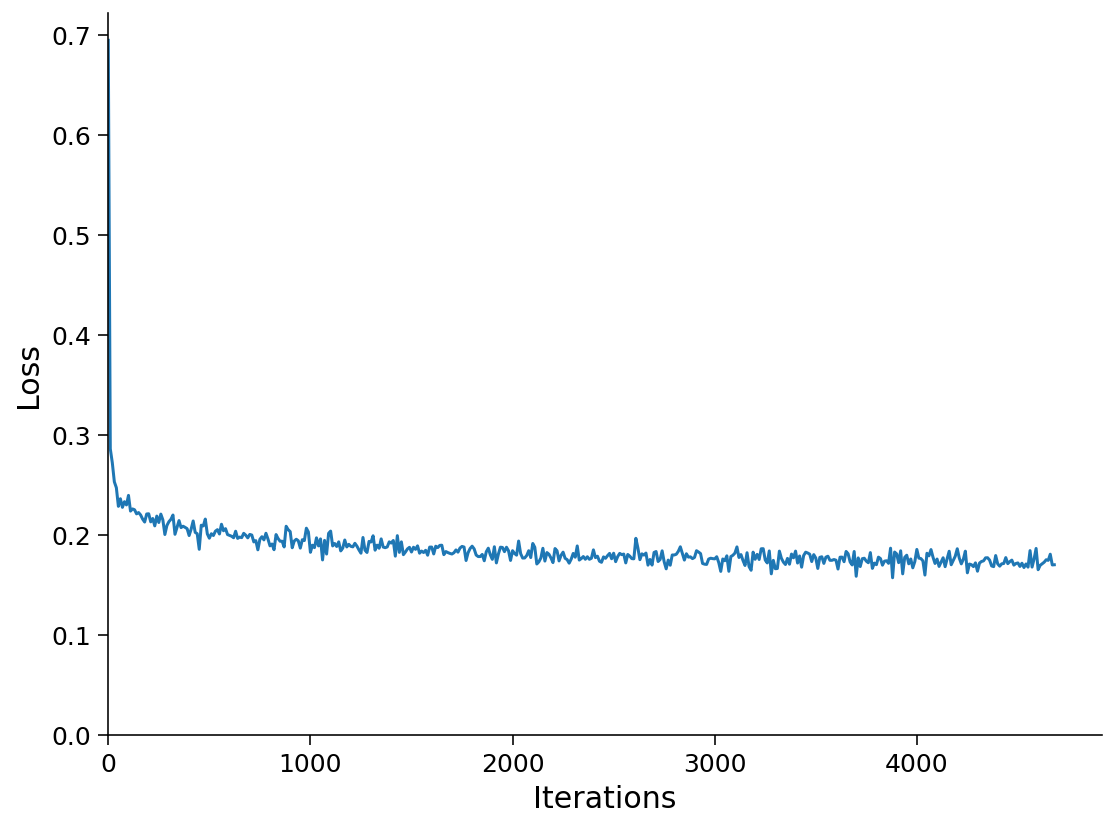

In [9]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs,
       batch_size=batch_size)

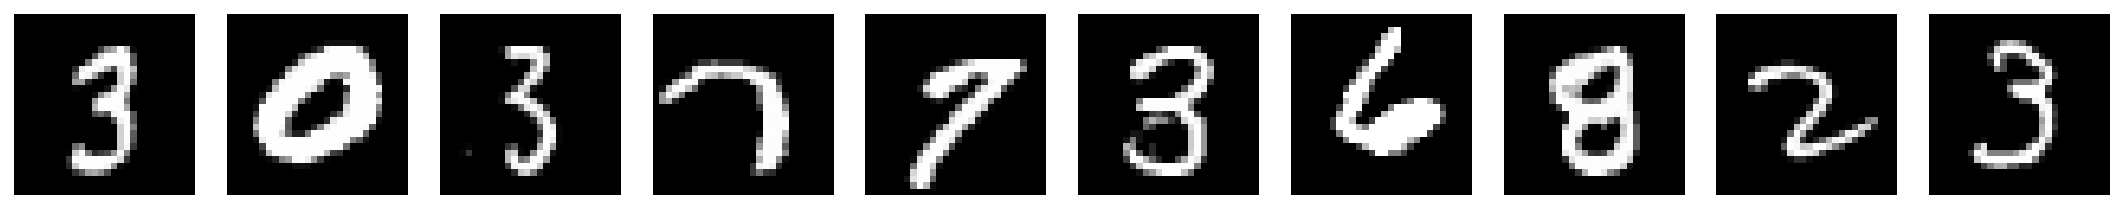

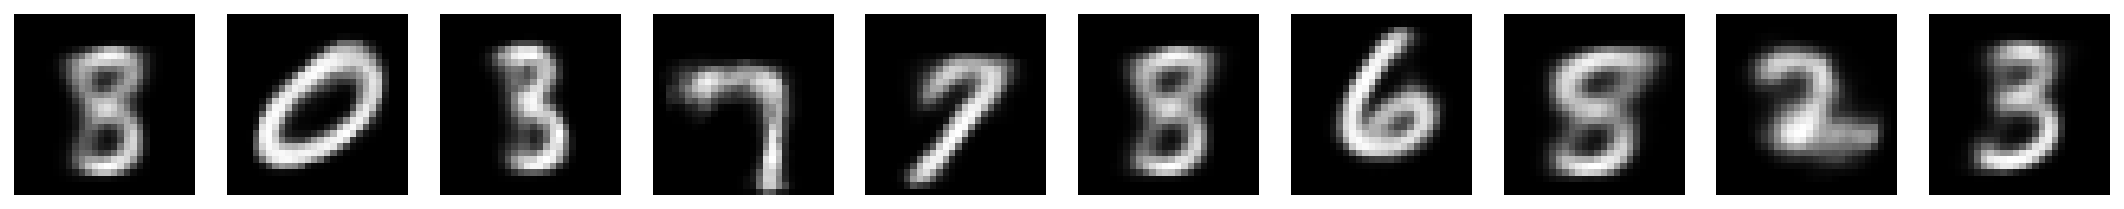

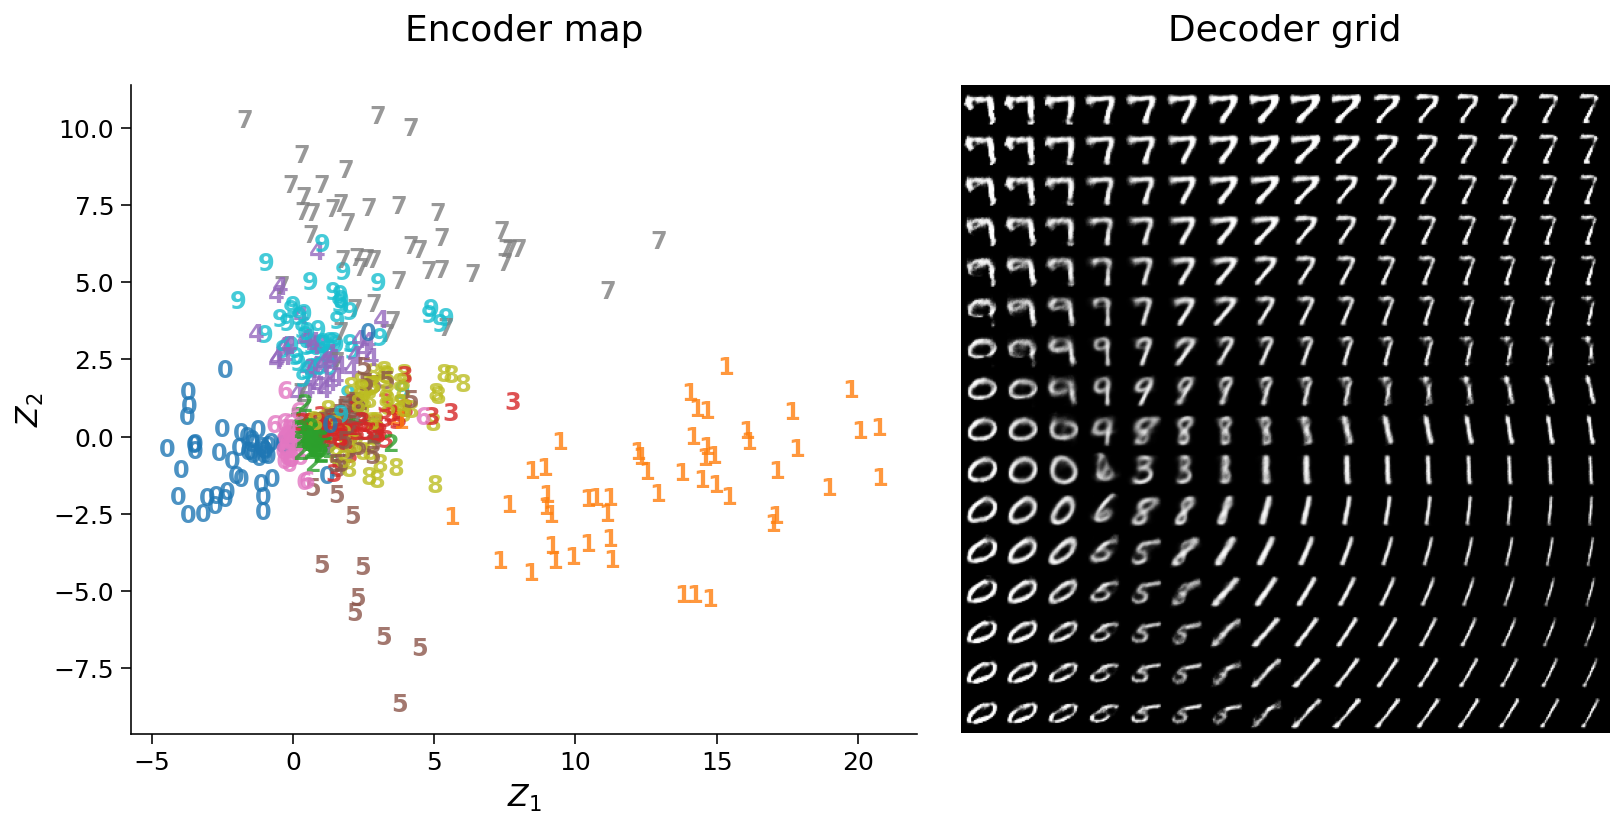

In [10]:
with torch.no_grad():
  output_test = model(input_test)
  latent_test = encoder(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder, image_shape=image_shape)

---
# Section 3: Spherical latent space

The previous architecture generates representations that typically spread in different directions from coordinate $(z_1, z_2)=(0,0)$. This effect is due to the initialization of weights distributed randomly around `0`.

Adding a third unit to the bottleneck layer defines a coordinate $(z_1, z_2, z_3)$ in 3D space. The latent space from such a network will still spread out from $(z_1, z_2, z_3)=(0, 0, 0)$.

Collapsing the latent space on the surface of a sphere removes the possibility of spreading unchecked from the origin $(0, 0, 0)$ in any direction since this will eventually lead back to the origin. This constraint generates a representation that fills the surface of the sphere.

&nbsp;

![Unit sphere S2](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/unit_sphere.png)

&nbsp;


Projecting to the surface of the sphere is implemented by dividing the coordinates $(z_1, z_2, z_3)$ by their $L_2$ norm.

$(z_1, z_2, z_3)\longmapsto (s_1, s_2, s_3)=(z_1, z_2, z_3)/\|(z_1, z_2, z_3)\|_2=(z_1, z_2, z_3)/ \sqrt{z_1^2+z_2^2+z_3^2}$

This mapping projects to the surface of the [$S_2$ sphere](https://en.wikipedia.org/wiki/N-sphere) with unit radius. (Why?)

## Section 3.1: Build and train autoencoder (3D)

We start by adding one unit to the bottleneck layer and visualize the latent space in 3D.

Please execute the cell below.

In [11]:
encoding_size = 3

model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, encoding_size),
    nn.PReLU(),
    nn.Linear(encoding_size, encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), input_size),
    nn.Sigmoid()
    )

model[:-2].apply(init_weights_kaiming_normal)

encoder = model[:6]
decoder = model[6:]

print(f'Autoencoder \n\n {model}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=3, out_features=96, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=96, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)


## Section 3.2: Train the autoencoder

Train the network for `n_epochs=10` epochs with `batch_size=128`. Observe how the internal representation spreads from the origin and reaches much lower loss due to the additional degree of freedom in the bottleneck layer.

**Instructions**
* Please execute the cell below:

Epoch 	 Loss train 	 Loss test
1/10	 0.1836		 0.1836
2/10	 0.1728		 0.1730
3/10	 0.1674		 0.1678
4/10	 0.1630		 0.1641
5/10	 0.1606		 0.1619
6/10	 0.1579		 0.1595
7/10	 0.1562		 0.1581
8/10	 0.1548		 0.1569
9/10	 0.1539		 0.1566
10/10	 0.1529		 0.1558

MSE	 0.0304		 0.0313
BCE	 0.1529		 0.1558


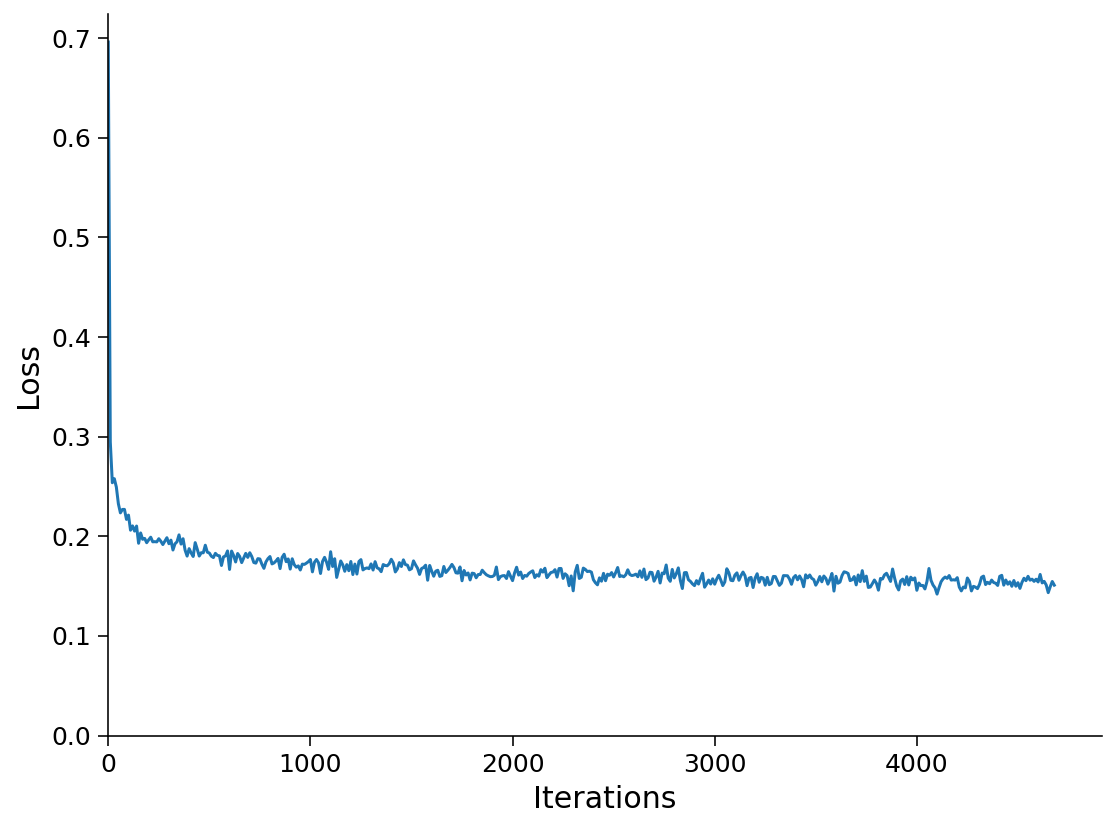

In [12]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs,
       batch_size=batch_size)

## Section 3.3: Visualize the latent space in 3D

**Helper function**: `plot_latent_3d`

Please uncomment the line below to inspect this function.

In [13]:
# help(plot_latent_3d)

In [14]:
with torch.no_grad():
  latent_test = encoder(input_test)
    
plot_latent_3d(latent_test, y_test)

### Exercise 2: Build deep autoencoder (2D) with latent spherical space
We now constrain the latent space to the surface of a sphere $S_2$.


**Instructions**
* Add the custom layer `NormalizeLayer` after the bottleneck layer
* Adjust the definitions of `encoder` and `decoder`
* Experiment with keyword `show_text=False` for `plot_latent_3d`

**Helper function**: `NormalizeLayer`

Please uncomment the line below to inspect this function.

In [15]:
# help(NormalizeLayer)

In [16]:
encoding_size = 3

model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, encoding_size),
    nn.PReLU(),
    #################################################
    ## TODO for students: add custom normalize layer
    #################################################
    # add the normalization layer
    # ...,
    nn.Linear(encoding_size, encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), input_size),
    nn.Sigmoid()
    )

model[:-2].apply(init_weights_kaiming_normal)

print(f'Autoencoder \n\n {model}\n')

# Adjust the value n_l to split your model correctly
# n_l = ...

# uncomment when you fill the code
# encoder = model[:n_l]
# decoder = model[n_l:]
# print(f'Encoder \n\n {encoder}\n')
# print(f'Decoder \n\n {decoder}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=3, out_features=96, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=96, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)



In [17]:
# to_remove solution
encoding_size = 3

model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, encoding_size),
    nn.PReLU(),
    # add the normalization layer
    NormalizeLayer(),
    nn.Linear(encoding_size, encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), input_size),
    nn.Sigmoid()
    )

model[:-2].apply(init_weights_kaiming_normal)

print(f'Autoencoder \n\n {model}\n')

# Adjust the value n_l to split your model correctly
n_l = 7

# uncomment when you fill the code
encoder = model[:n_l]
decoder = model[n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Decoder \n\n {decoder}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): NormalizeLayer()
  (7): Linear(in_features=3, out_features=96, bias=True)
  (8): PReLU(num_parameters=1)
  (9): Linear(in_features=96, out_features=392, bias=True)
  (10): PReLU(num_parameters=1)
  (11): Linear(in_features=392, out_features=784, bias=True)
  (12): Sigmoid()
)

Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): NormalizeLayer()
)

Decoder 

 Sequential(
  (7): Linear(in_features=3, out_features=96, bias=True)
  (8): PReLU(num_par

## Section 3.4: Train the autoencoder
Train the network for `n_epochs=10` epochs with `batch_size=128` and observe how loss raises again and is comparable to the model with 2D latent space.

**Instructions**
* Please execute the cell below:

Epoch 	 Loss train 	 Loss test
1/10	 0.2016		 0.2021
2/10	 0.1910		 0.1912
3/10	 0.1845		 0.1848
4/10	 0.1793		 0.1797
5/10	 0.1770		 0.1775
6/10	 0.1751		 0.1760
7/10	 0.1734		 0.1742
8/10	 0.1721		 0.1729
9/10	 0.1708		 0.1716
10/10	 0.1719		 0.1725

MSE	 0.0368		 0.0371
BCE	 0.1719		 0.1725


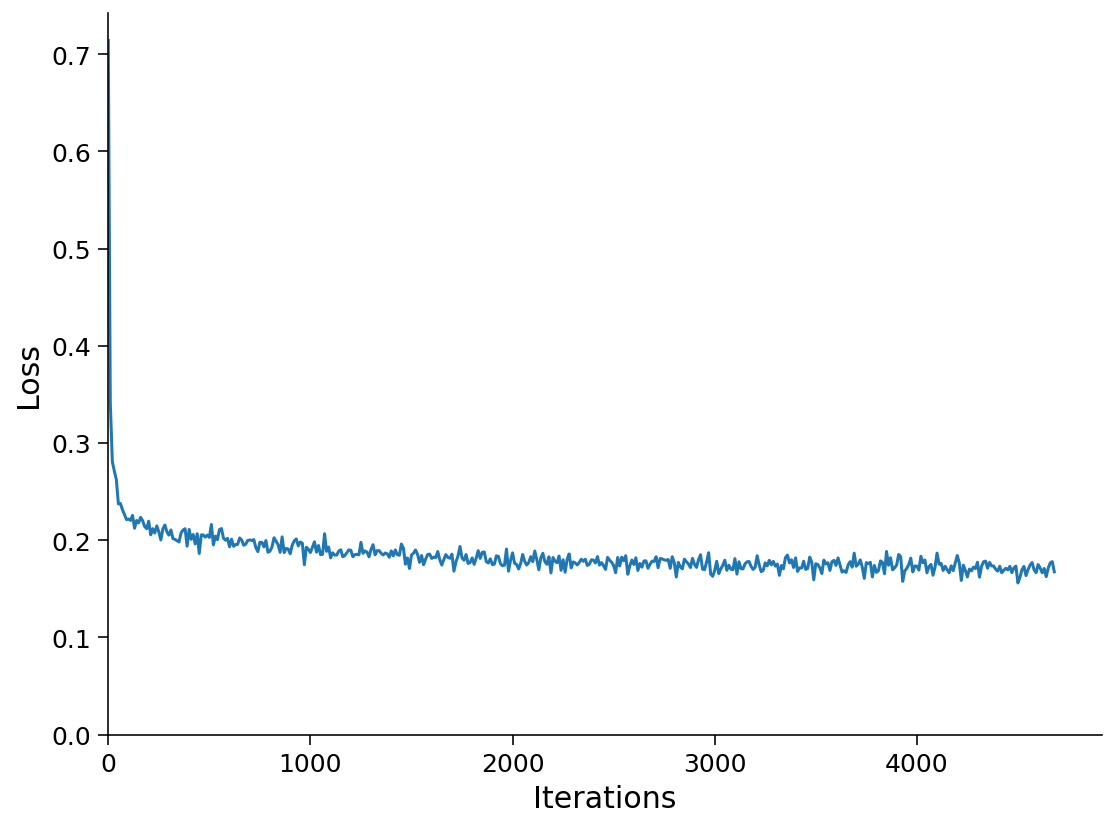

In [18]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs,
       batch_size=batch_size)

In [19]:
with torch.no_grad():
  latent_test = encoder(input_test)
    
plot_latent_3d(latent_test, y_test)

## Section 3.5: Visualize latent space on surface of $S_2$
The 3D coordinates $(s_1, s_2, s_3)$ on the surface of the unit sphere $S_2$  can be mapped to [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system) $(r, \theta, \phi)$, as follows:

$$
\begin{aligned}
r &= \sqrt{s_1^2 + s_2^2 + s_3^2} \\
\phi &= \arctan \frac{s_2}{s_1} \\
\theta &= \arccos\frac{s_3}{r}
\end{aligned}
$$

![Spherical coordinates](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/spherical_coords.png)

What is the domain (numerical range) spanned by ($\theta, \phi)$?

We return to a 2D representation since the angles $(\theta, \phi)$ are the only degrees of freedom on the surface of the sphere. Add the keyword `s2=True` to `plot_latent_generative` to un-wrap the sphere's surface similar to a world map.

Task: Check the numerical range of the plot axis to help identify $\theta$ and $\phi$, and visualize the unfolding of the 3D plot from the previous exercise.

**Instructions:**
* Please execute the cells below

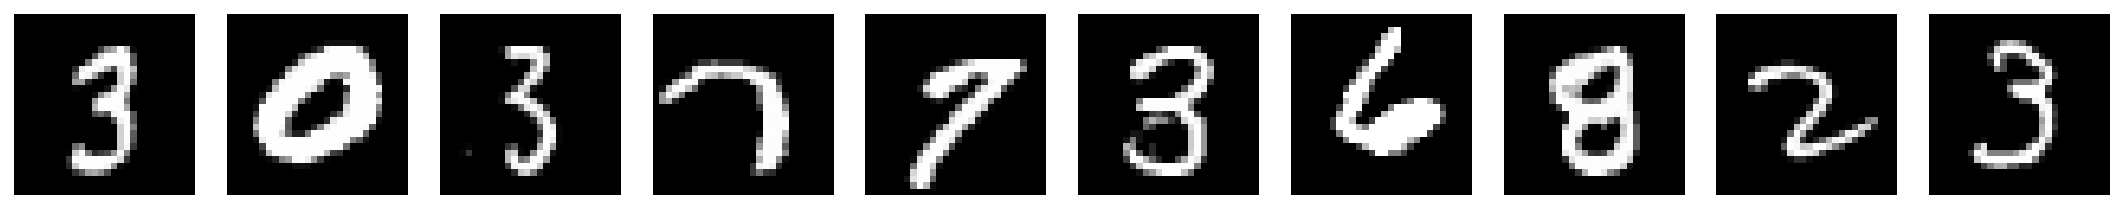

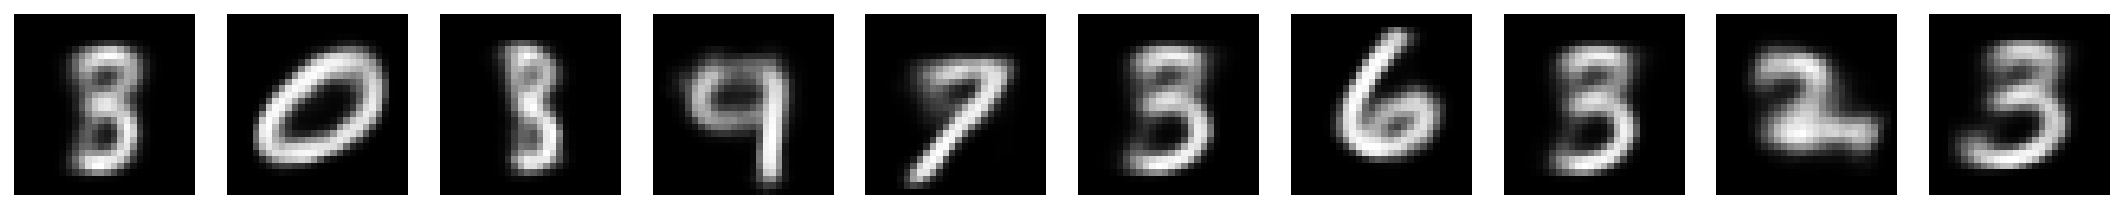

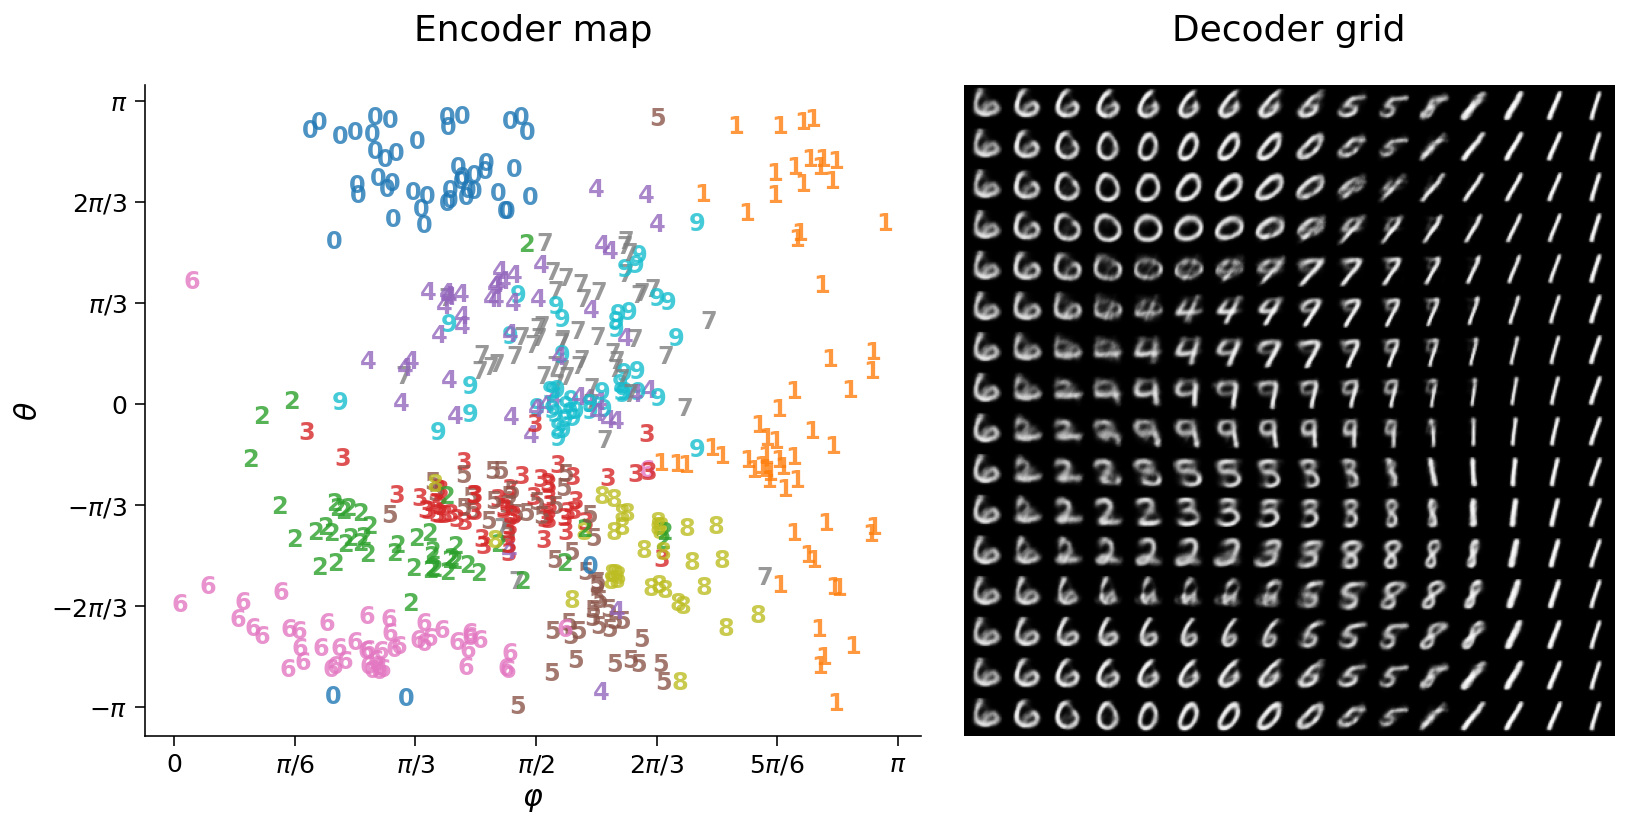

In [20]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder,
                       image_shape=image_shape, s2=True)

---
# Summary
We learned two techniques to improve representation capacity: adding a few hidden layers and projecting latent space on the sphere $S_2$.

The expressive power of autoencoder improves with additional hidden layers. Projecting latent space on the surface of $S_2$ spreads out digits classes in a more visually pleasing way but may not always produce a lower loss.

**Deep autoencoder architectures have rich internal representations to deal with sophisticated tasks such as the MNIST cognitive task.**

We now have powerful tools to explore how simple algorithms build robust models of the world by capturing relevant data patterns.

In [21]:
#@title Video 2: Wrap-up
# from IPython.display import YouTubeVideo
# video = YouTubeVideo(id="Lb2ycpMC7oM", width=854, height=480, fs=1)
# print("Video available at https://youtube.com/watch?v=" + video.id)
# video

---
# Bonus

## Deep and thick autoencoder
In this exercise, we first expand the first hidden layer to double the input size, followed by compression to half the input size leading to 3.8M parameters. Please **do not train this network during tutorial** due to long training time.

**Instructions**
* Uncomment the last two cells
* Please execute the cells below

In [22]:
# encoding_size = 3

# model = nn.Sequential(
#     nn.Linear(input_size, int(input_size * 2)),
#     nn.PReLU(),
#     nn.Linear(int(input_size * 2), int(input_size / 2)),
#     nn.PReLU(),
#     nn.Linear(int(input_size / 2), encoding_size * 32),
#     nn.PReLU(),
#     nn.Linear(encoding_size * 32, encoding_size),
#     nn.PReLU(),
#     NormalizeLayer(),
#     nn.Linear(encoding_size, encoding_size * 32),
#     nn.PReLU(),
#     nn.Linear(encoding_size * 32, int(input_size / 2)),
#     nn.PReLU(),
#     nn.Linear(int(input_size / 2), int(input_size * 2)),
#     nn.PReLU(),
#     nn.Linear(int(input_size * 2), input_size),
#     nn.Sigmoid()
#     )

# model[:-2].apply(init_weights_kaiming_normal)

# encoder = model[:9]
# decoder = model[9:]

# print_parameter_count(model)

In [23]:
# n_epochs = 5
# batch_size = 128

# runSGD(model, input_train, input_test, n_epochs=n_epochs,
#        batch_size=batch_size)

# Visualization
# with torch.no_grad():
#   output_test = model(input_test)

# plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
#          image_shape=image_shape)

# plot_latent_generative(latent_test, y_test, decoder, 
#                        image_shape=image_shape, s2=True)